In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras import objectives
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Multiply, Add
from keras.optimizers import Adam, Nadam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from random import shuffle
import pandas as pd
import random

#Keras build
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

#chem
from rdkit import Chem
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import salty
import gains as genetic

#cation data
cations = pd.read_csv('../data/cations.csv')
cations = cations['smiles_string']
salts = pd.read_csv('../data/salts.csv')
salts = salts['smiles_string']
categories = pd.read_csv('../data/categories.csv')
categories = categories['category']
coldic = pd.read_csv('../data/coldic.csv')
coldic = coldic.to_dict(orient='records')[0]
salt_coldic = pd.read_csv('../data/salt_coldic.csv')
salt_coldic = salt_coldic.to_dict(orient='records')[0]
salt_categories = pd.read_csv('../data/salt_categories.csv')
salt_categories = salt_categories['category']
density_coldic = pd.read_csv('../data/density_coldic.csv')
density_coldic = density_coldic.to_dict(orient='records')[0]
density_categories = pd.read_csv('../data/density_categories.csv')
density_categories = density_categories['category']

#supporting functions
import sys
sys.path.insert(0, '../')
from scripts import *

#training array info
smile_max_length = 105
import json
f = open("../data/salt_char_to_index.json","r")
ani_char_to_index = json.loads(f.read())
ani_char_set = set(ani_char_to_index.keys())
ani_char_list = list(ani_char_to_index.keys())
ani_chars_in_dict = len(ani_char_list)
ani_index_to_char = dict((i, c) for i, c in enumerate(ani_char_list))

#training array info
import json
f = open("../data/gdb_char_to_index.json","r")
cat_char_to_index = json.loads(f.read())
cat_char_set = set(cat_char_to_index.keys())
cat_char_list = list(cat_char_to_index.keys())
cat_chars_in_dict = len(cat_char_list)
cat_index_to_char = dict((i, c) for i, c in enumerate(cat_char_list))

char_to_index = ani_char_to_index
char_set = ani_char_set
char_list = ani_char_list
chars_in_dict = ani_chars_in_dict
index_to_char = ani_index_to_char

from rdkit.ML.Descriptors.MoleculeDescriptors import\
    MolecularDescriptorCalculator as calculator

def _get_fitness(anion, genes, target, models, deslists):
    """
    the fitness function passed to the engine.

    Parameters
    ----------
    anion : RDKit Mol Object
        the anion comprising the IL
    genes : str
        the smiles string representing the cation of the IL
    target : list, int, or array
        the target property values of the IL
    models : array of, or single Keras model
        array or single keras model to use in the prediction
        of the targets
    deslists : array of, or single pandas dataFrame
        contains the mean and stds of the model inputs

    """
    predictions = []
    for i, name in enumerate(models):
        cation = Chem.MolFromSmiles(genes)
        model = name
        deslist = deslists[i]
        if isinstance(deslist, list):
            deslist = deslist[0]
        feature_vector = []

        for item in deslist:

            if "anion" in item:
                with genetic.suppress_rdkit_sanity():
                    feature_vector.append(calculator([item.partition('-')
                                          [0]]).CalcDescriptors(anion)[0])
            elif "cation" in item:
                with genetic.suppress_rdkit_sanity():
                    feature_vector.append(calculator([item.partition('-')
                                          [0]]).CalcDescriptors(cation)[0])
            elif "Temperature, K" in item:
                feature_vector.append(298.15)
            elif "Pressure, kPa" in item:
                feature_vector.append(101.325)
            else:
                print("unknown descriptor in list: %s" % item)
        features_normalized = (feature_vector - deslist.iloc[0].values) /\
            deslist.iloc[1].values
        prediction = np.round(np.exp(model.predict(np.array(
                              features_normalized).reshape(1, -1))[0]),
                              decimals=2)
        predictions.append(prediction[0])
    predictions = np.array(predictions)
    error = abs((predictions - target) / target)
    error = np.average(error)

    return 1 - error, predictions

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
ls -t ../data/*function*

../data/gen1vae_no_target_4073_function_calls
../data/gen2vae_no_target_13968_function_calls
../data/gen3vae_no_target_2597_function_calls
../data/df_gen3vae_viscosity_no_qspr_91102_function_calls
../data/df_gen3vae_viscosity_qspr_100847_function_calls
../data/df_ea_viscosity_2663_function_calls
../data/df_gen3vae_thermal_conductivity_qspr_38305_function_calls
../data/df_ea_thermal_conductivity_521_function_calls
../data/df_ea_density_3050_function_calls
../data/df_ea_cpt_2169_function_calls
../data/df_gen3vae_thermal_conductivity_no_qspr_43903_function_calls
../data/df_gen3vae_density_qspr_4567_function_calls
../data/df_gen3vae_density_no_qspr_7840_function_calls
../data/df_gen3vae_density_qspr_4866_function_calls
../data/df_ea_density_28397_function_calls
../data/df_gen3vae_cpt_no_qspr_15320_function_calls
../data/df_ea_cpt_1770_function_calls
../data/df_gen3vae_cpt_qspr_10055_function_calls
../data/df_gen3vae_cpt_qspr_10172_function_calls
../data/df_gen3vae_density_no_qspr_7891_func

In [4]:
function_call_di = {'heat capacity (1739 datapoints)' : {'vae no qspr' : 15320,
                                       'vae with qspr': 10055,
                                       'ea': 2169},
                    'density (5631 datapoints)': {'vae no qspr': 7840, 
                                'vae with qspr': 4567,
                                'ea': 3050},
                    'thermal conductivity (148 datapoints)': {'vae no qspr': 43903,
                                            'vae with qspr': 38305,
                                            'ea': 521},
                    'viscosity (3277 datapoints)': {'vae no qspr': 91102,
                                            'vae with qspr': 100847,
                                            'ea': 2663}}

In [5]:
pd.DataFrame(function_call_di)

,density (5631 datapoints),heat capacity (1739 datapoints),thermal conductivity (148 datapoints),viscosity (3277 datapoints)
ea,3050,2169,521,2663
vae no qspr,7840,15320,43903,91102
vae with qspr,4567,10055,38305,100847


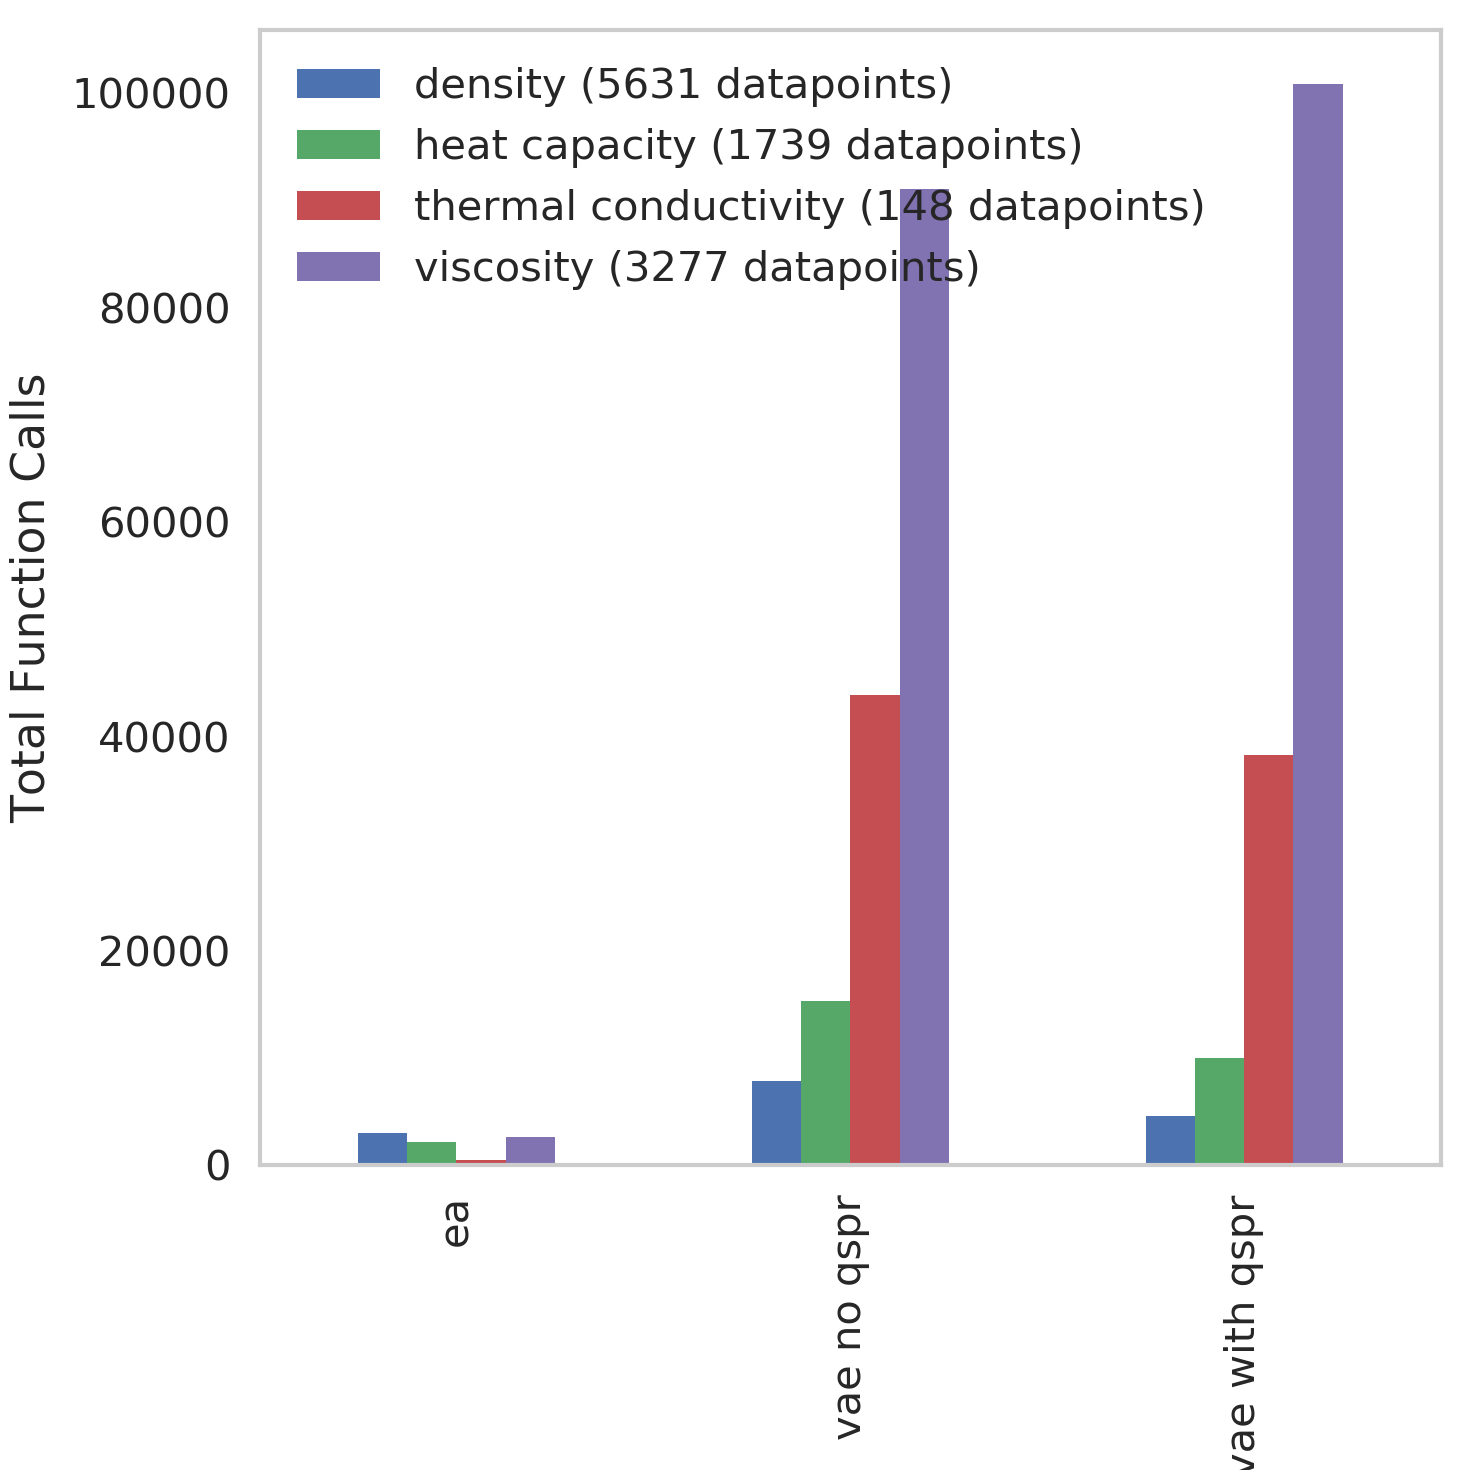

In [31]:
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
    pd.DataFrame(function_call_di).plot.bar(ax=ax)
    ax.set_ylabel('Total Function Calls')
    plt.grid()
    plt.tight_layout()

In [32]:
fig.savefig('assets/generative_model_comparison.svg')

In [110]:
df = pd.read_csv('../data/df_gen3vae_cpt_qspr_10055_function_calls')
df.columns

Index(['ani seed', 'attempts', 'candidate', 'cat seed', 'rdkit qspr',
       'rdkit-md qspr', 'salt', 'temperature', 'vae qspr'],
      dtype='object')

In [111]:
df.sort_values(['rdkit-md qspr'], inplace=True)

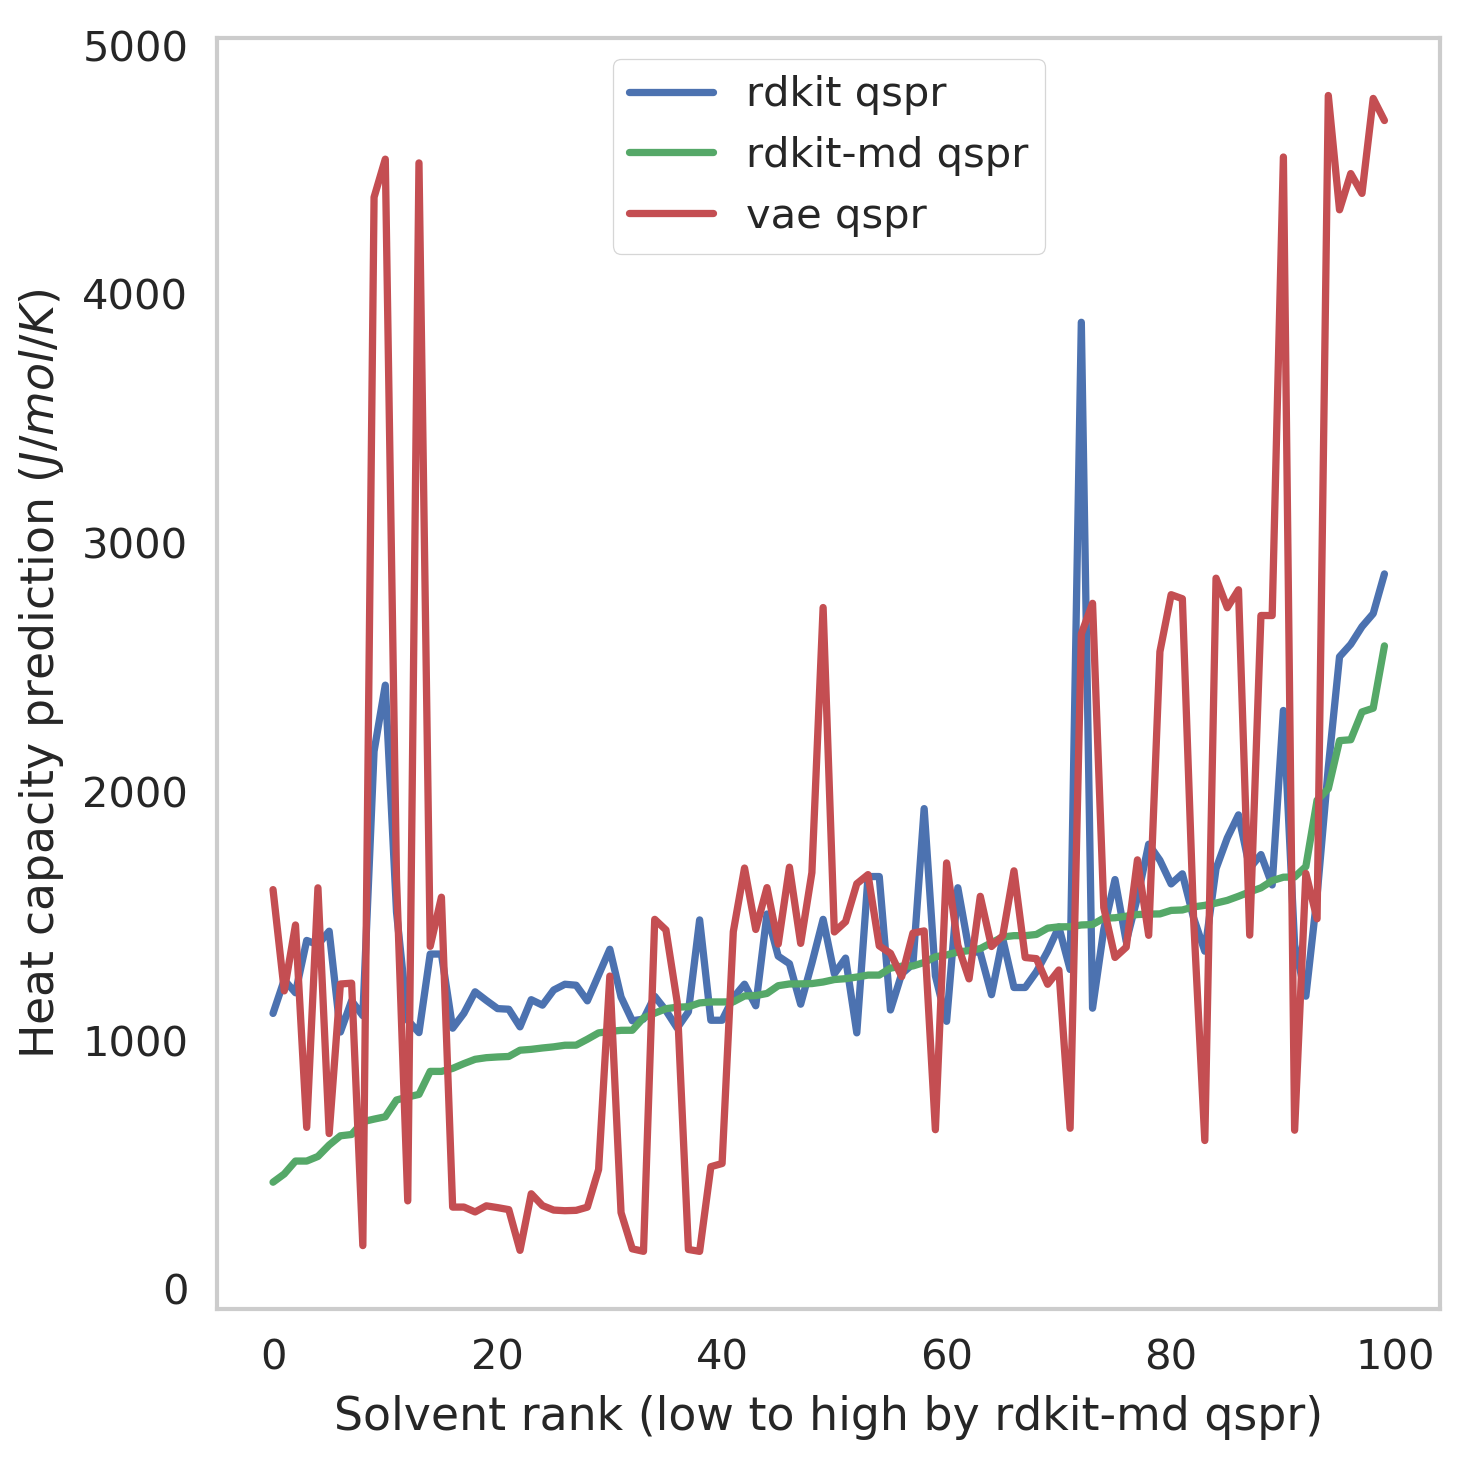

In [119]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
#     ax2 = ax.twinx()
    ax.plot(np.arange(0,df.shape[0],1), df['rdkit qspr'])
    ax.plot(np.arange(0,df.shape[0],1), df['rdkit-md qspr'])
    ax.plot(np.arange(0,df.shape[0],1), df['vae qspr'])
    ax.set_xlabel('Solvent rank (low to high by rdkit-md qspr)')
    ax.set_ylabel('Heat capacity prediction $(J/mol/K)$')
#     ax2.plot(np.arange(0,df.shape[0],1), df['temperature'], 
#              c='tab:grey', ls='--', alpha=0.6)
#     h1, l1 = ax.get_legend_handles_labels()
#     h2, l2 = ax2.get_legend_handles_labels()
#     ax.legend(h1+h2, l1+l2, frameon=True)#, bbox_to_anchor=(1.5, .85))
    ax.legend(frameon=True)
    fig.tight_layout()
    ax.grid()
#     ax2.grid()

In [121]:
df = pd.read_csv('../data/df_gen3vae_density_qspr_4567_function_calls')
df.columns

Index(['ani seed', 'attempts', 'candidate', 'cat seed', 'rdkit qspr',
       'rdkit-md qspr', 'salt', 'temperature', 'vae qspr'],
      dtype='object')

In [122]:
df.sort_values(['rdkit qspr'], inplace=True, ascending=False)

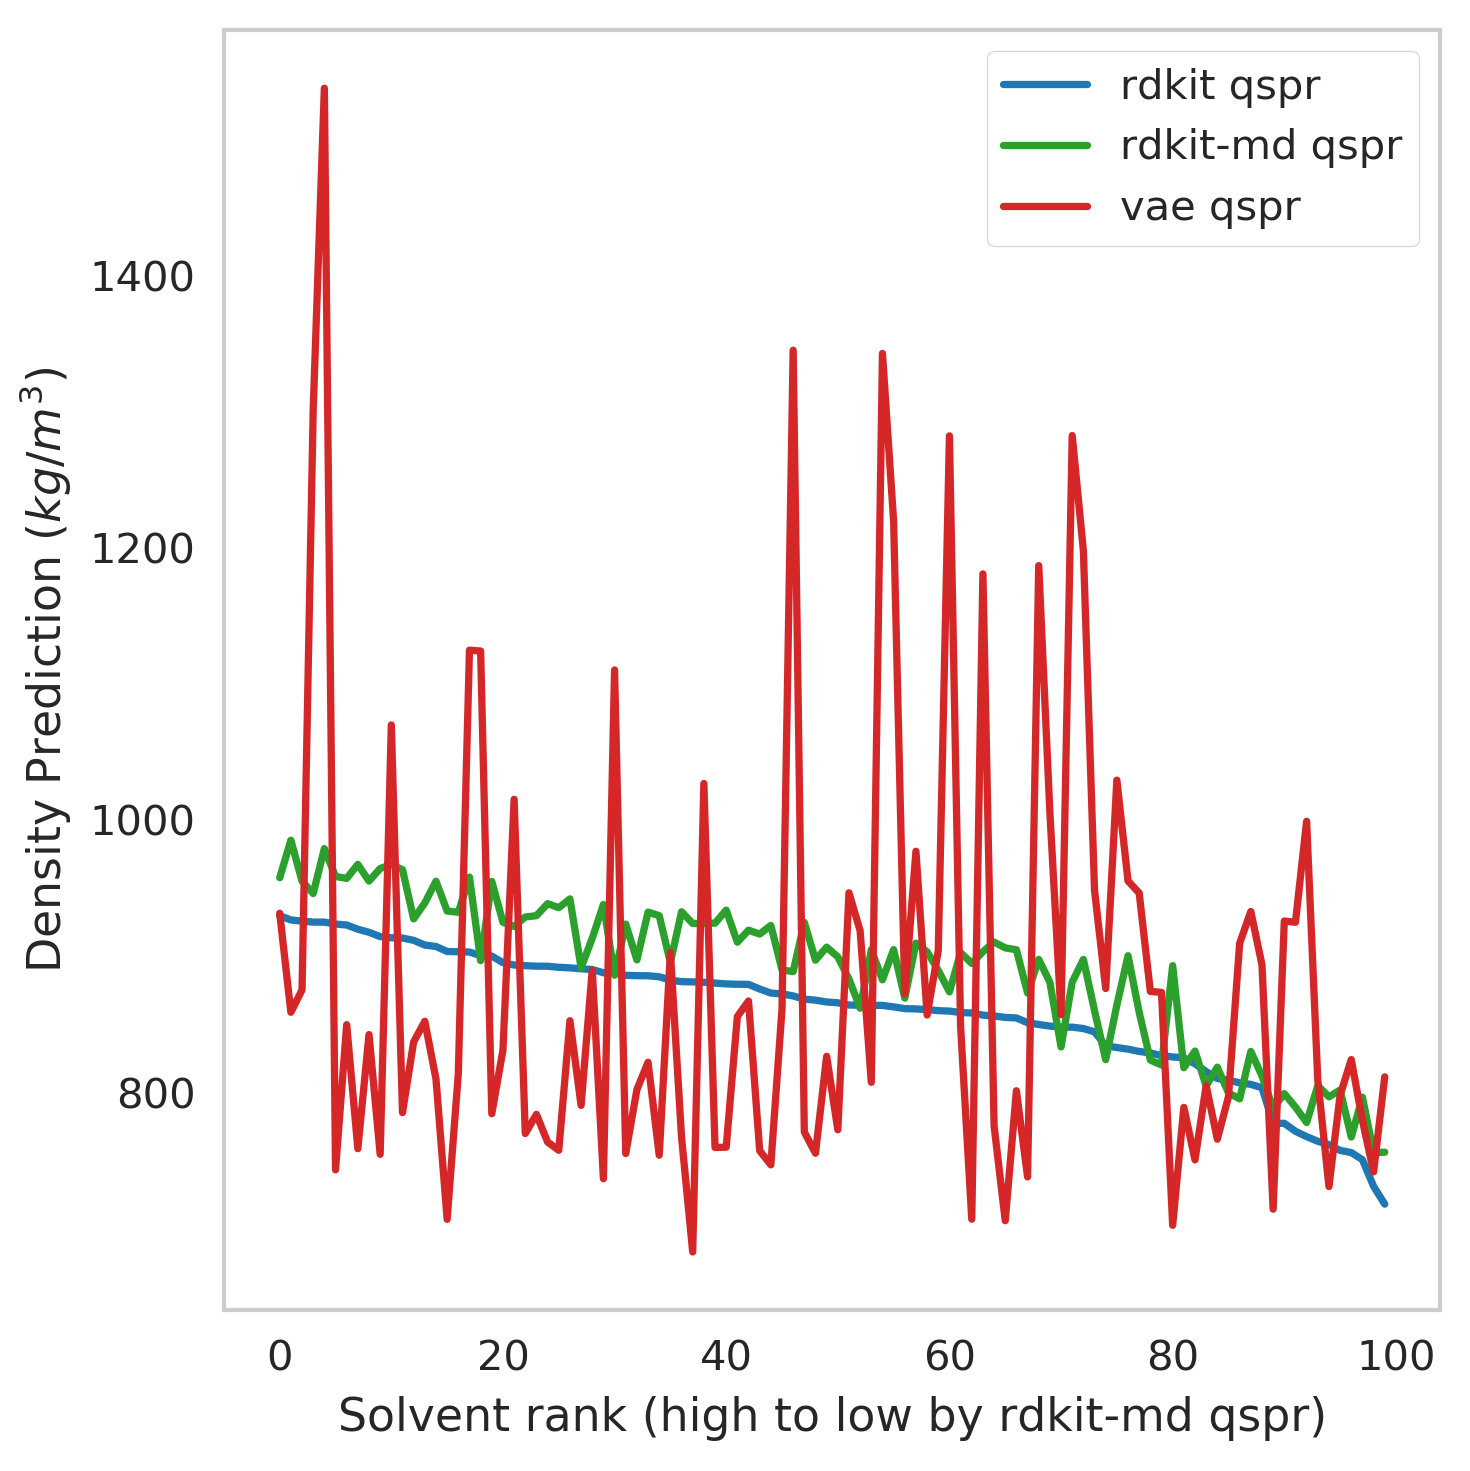

In [123]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
with plt.style.context('seaborn-whitegrid'):
    fig, ax = plt.subplots(1, figsize=(5,5), dpi=300)
#     ax2 = ax.twinx()
    ax.plot(np.arange(0,df.shape[0],1), df['rdkit qspr'], c='tab:blue')
    ax.plot(np.arange(0,df.shape[0],1), df['rdkit-md qspr'], c='tab:green')
    ax.plot(np.arange(0,df.shape[0],1), df['vae qspr'], c='tab:red')
    ax.set_xlabel('Solvent rank (high to low by rdkit-md qspr)')
    ax.set_ylabel('Density Prediction $(kg/m^3)$')
#     ax2.plot(np.arange(0,df.shape[0],1), df['temperature'], 
#              c='tab:grey', ls='--', alpha=0.6)
#     h1, l1 = ax.get_legend_handles_labels()
#     h2, l2 = ax2.get_legend_handles_labels()
#     ax.legend(h1+h2, l1+l2, frameon=True)#, bbox_to_anchor=(1.5, .85))
    ax.legend(frameon=True)
    ax.grid()
    ax2.grid()
    fig.tight_layout()